In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torchvision import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
experiment_log = pd.read_csv("./results/circle_mini_batch_size_lr_experiment_log.csv", header=0, index_col=None,encoding="utf-8")
max_dataset_training_times = experiment_log.groupby("DATASET")["TOTAL TRAINING TIME"].max()
for dataset_name, dataset_experiment_log in experiment_log.groupby("DATASET"):
    experiment_log.loc[experiment_log["DATASET"]==dataset_name, "TOTAL TRAINING TIME NORMALIZED"] = dataset_experiment_log["TOTAL TRAINING TIME"] / max_dataset_training_times[dataset_name]
experiment_log

,DATASET,OPTIMIZER,LOSS,MINI-BATCH SIZE,LEARNING RATE,TRAINING LOSS,TRAINING ACCURACY,TRAINING F1,VALIDATION LOSS,VALIDATION ACCURACY,VALIDATION F1,TOTAL TRAINING TIME,TEST LOSS,TEST ACCURACY,TEST F1,CONVERGED AT EPOCH,TOTAL TRAINING TIME NORMALIZED
0,circle,sgd,mse,1,0.050000,0.015827,0.973333,0.973320,0.006596,1.00,1.000000,241.211301,0.014312,0.986,0.985995,0.002222,0.443263
1,circle,sgd,mse,1,0.069475,0.016732,0.967778,0.967756,0.008736,0.99,0.989997,262.727371,0.015220,0.978,0.977980,0.002222,0.482802
2,circle,sgd,mse,1,0.096535,0.018064,0.960000,0.959984,0.007148,0.99,0.989997,251.400040,0.015490,0.978,0.977990,0.002222,0.461986
3,circle,sgd,mse,1,0.134135,0.020321,0.964444,0.964440,0.006521,0.99,0.989997,251.127950,0.014766,0.979,0.978991,0.002222,0.461486
4,circle,sgd,mse,1,0.186380,0.024074,0.951111,0.951060,0.015995,0.98,0.979984,255.144301,0.023988,0.969,0.968973,0.002222,0.468867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,circle,sgd_to_half,cross_entropy,900,1.341348,0.529705,0.952222,0.952210,0.547763,0.93,0.929979,0.743442,0.532117,0.951,0.950980,0.000000,0.001366
6746,circle,sgd_to_half,cross_entropy,900,1.863797,0.476082,0.963333,0.963332,0.493771,0.95,0.949985,0.735107,0.478347,0.955,0.954993,0.000000,0.001351
6747,circle,sgd_to_half,cross_entropy,900,2.589737,0.427453,0.967778,0.967775,0.449780,0.97,0.970003,0.735034,0.432946,0.973,0.973004,0.000000,0.001351
6748,circle,sgd_to_half,cross_entropy,900,3.598428,0.434037,0.966667,0.966668,0.456912,0.99,0.990001,0.744006,0.439707,0.973,0.973004,66.000000,0.001367


In [86]:
score_variances = experiment_log[["TEST F1", "TOTAL TRAINING TIME NORMALIZED"]].std()
total_variance = score_variances.sum()
print(score_variances)
score_coefficients = (total_variance - score_variances) / total_variance
print(score_coefficients)
experiment_log["COMBINED SCORE"] = \
(experiment_log["TEST F1"] - experiment_log["TEST F1"].mean()) / experiment_log["TEST F1"].std() - (experiment_log["TOTAL TRAINING TIME"] - experiment_log["TOTAL TRAINING TIME"].mean()) / experiment_log["TOTAL TRAINING TIME"].std()
experiment_log[["TEST F1", "TOTAL TRAINING TIME", "COMBINED SCORE"]]

TEST F1                           0.144244
TOTAL TRAINING TIME NORMALIZED    0.086274
dtype: float64
TEST F1                           0.374262
TOTAL TRAINING TIME NORMALIZED    0.625738
dtype: float64


,TEST F1,TOTAL TRAINING TIME,COMBINED SCORE
0,0.985995,241.211301,-4.183883
1,0.977980,262.727371,-4.697746
2,0.977990,251.400040,-4.456401
3,0.978991,251.127950,-4.443662
4,0.968973,255.144301,-4.598664
...,...,...,...
6745,0.950980,0.743442,0.695380
6746,0.954993,0.735107,0.723378
6747,0.973004,0.735034,0.848242
6748,0.973004,0.744006,0.848051


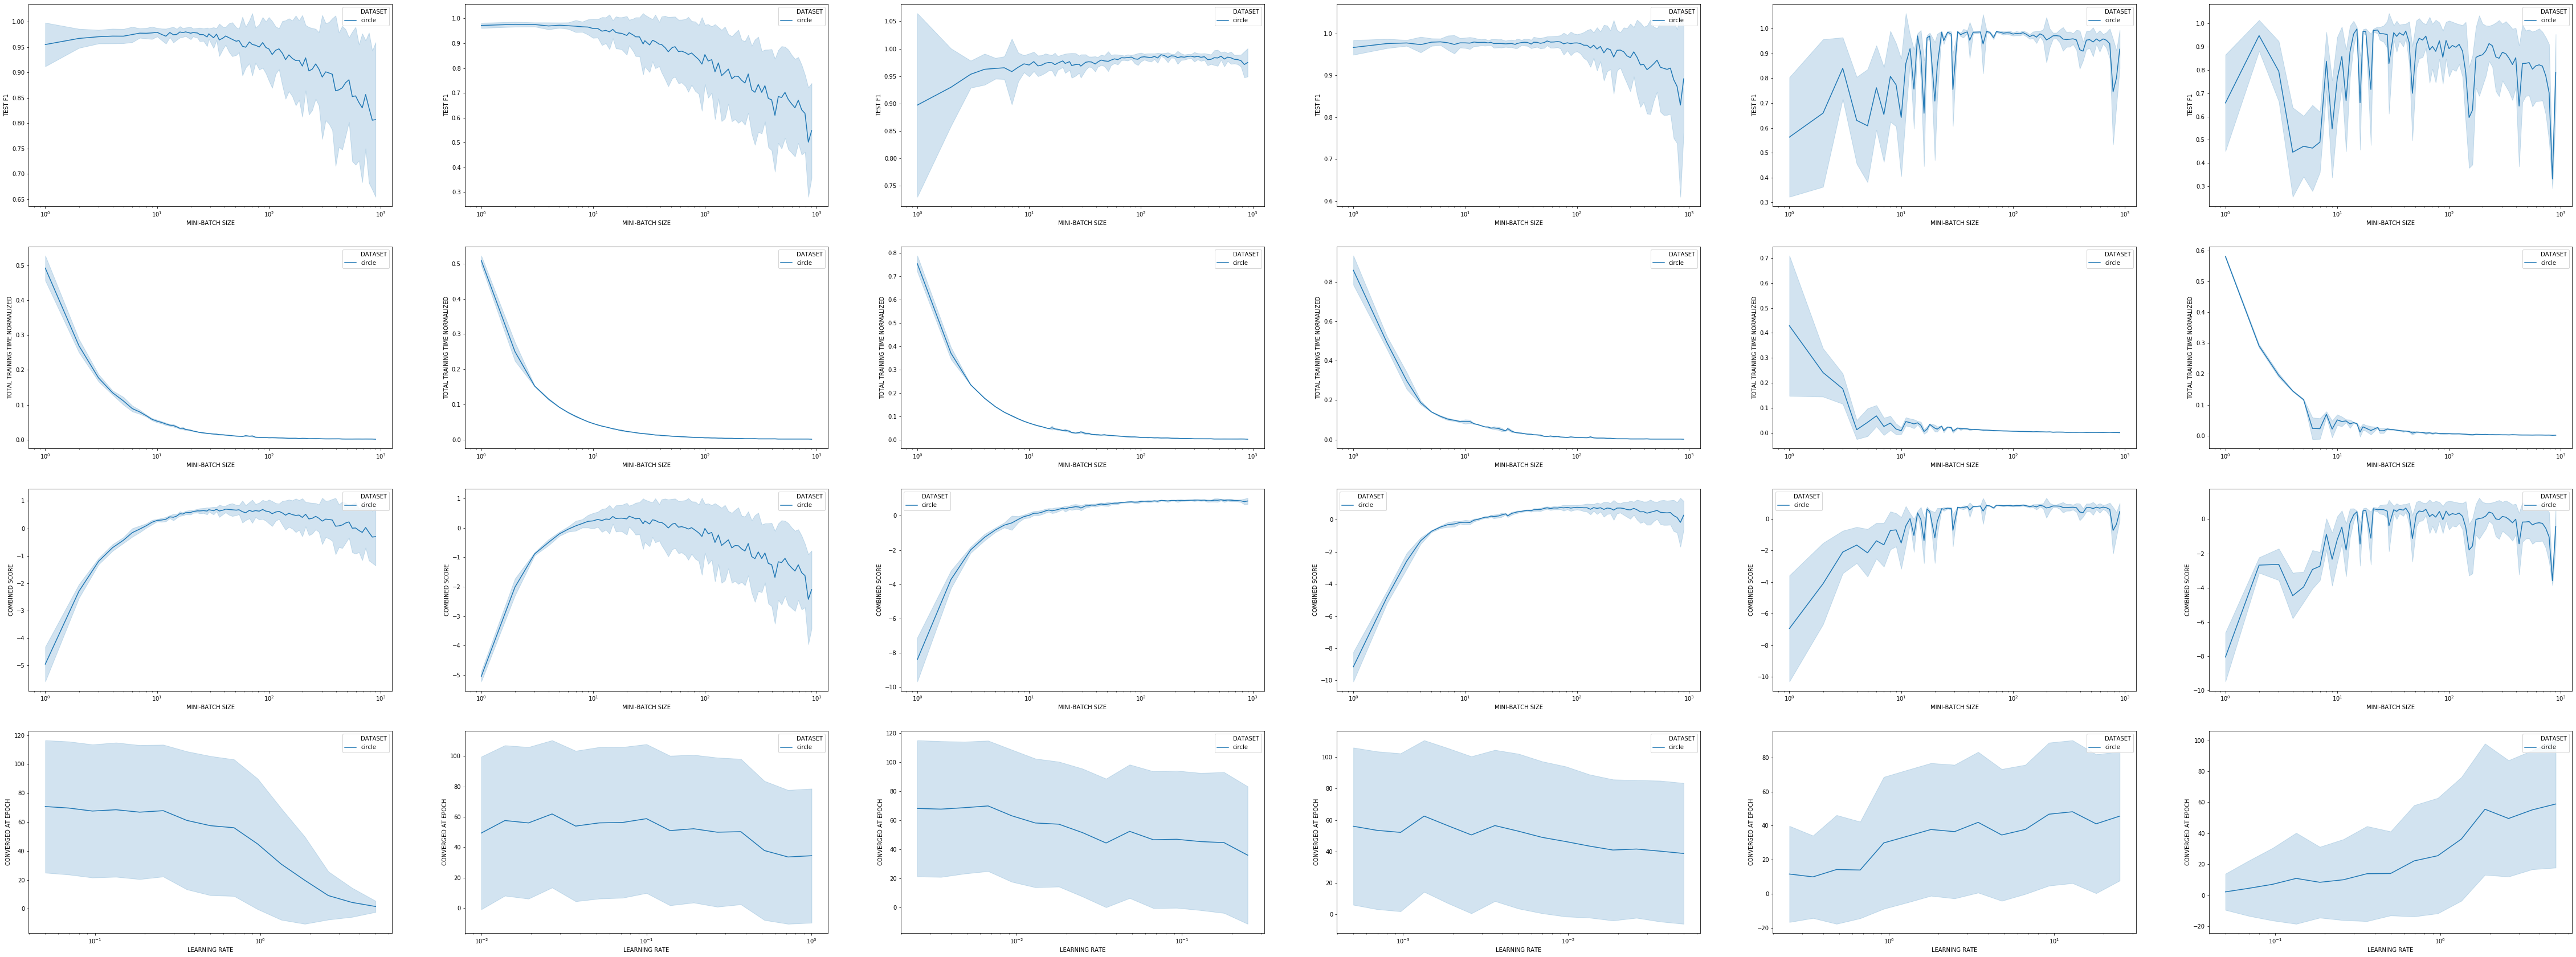

In [97]:
target_variables = ["TEST F1", "TOTAL TRAINING TIME NORMALIZED", "COMBINED SCORE", "CONVERGED AT EPOCH"]
optimizer_loss_conditions = [(optimizer_algorithm, loss_function)
                             for optimizer_algorithm in ("sgd", "adam", "sgd_to_half")
                             for loss_function in ("mse", "cross_entropy")]
datasets = ["circle", "mnist", "fashion_mnist"]

fig, ax = plt.subplots(len(target_variables), len(optimizer_loss_conditions),
                       figsize=(20 * len(target_variables), 5 * len(optimizer_loss_conditions)))
for i, target_variable in enumerate(target_variables):
    for j, optimizer_loss_condition in enumerate(optimizer_loss_conditions):
            optimizer, loss = optimizer_loss_condition
            plot_data = experiment_log[(experiment_log["OPTIMIZER"] == optimizer)
                                        & (experiment_log["LOSS"] == loss)]
            sns.lineplot(x="LEARNING RATE" if target_variable=="CONVERGED AT EPOCH" else "MINI-BATCH SIZE", y=target_variable, hue="DATASET", ci="sd", data=plot_data, ax=ax[i, j])
            ax[i, j].set_xscale("log")          
plt.show()

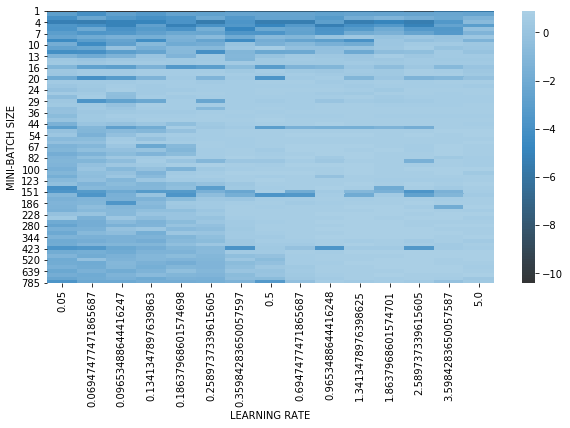

In [95]:
plot_data = experiment_log[(experiment_log["OPTIMIZER"] == "sgd_to_half") & (experiment_log["LOSS"] == "cross_entropy")].pivot("MINI-BATCH SIZE", "LEARNING RATE", "COMBINED SCORE")
plt.figure(figsize=(10, 5))
sns.heatmap(plot_data, cmap=sns.color_palette("Blues_d", n_colors=100))
plt.show()

In [96]:
optimal_values_indices = experiment_log[experiment_log["CONVERGED AT EPOCH"] < 100].groupby(["DATASET", "OPTIMIZER", "LOSS"])["COMBINED SCORE"].idxmax()
experiment_log.loc[optimal_values_indices, ["DATASET", "OPTIMIZER", "LOSS", "MINI-BATCH SIZE", "LEARNING RATE", "CONVERGED AT EPOCH", "TEST F1"]]

,DATASET,OPTIMIZER,LOSS,MINI-BATCH SIZE,LEARNING RATE,CONVERGED AT EPOCH,TEST F1
4377,circle,adam,cross_entropy,520,0.025897,48.500000,0.994000
3374,circle,adam,mse,900,0.250000,3.000000,0.994000
1678,circle,sgd,cross_entropy,67,0.719686,0.142857,0.992001
777,circle,sgd,mse,186,2.589737,10.600000,0.990999
6521,circle,sgd_to_half,cross_entropy,322,1.863797,99.666667,0.980002
5230,circle,sgd_to_half,mse,151,6.706739,21.666667,0.993001


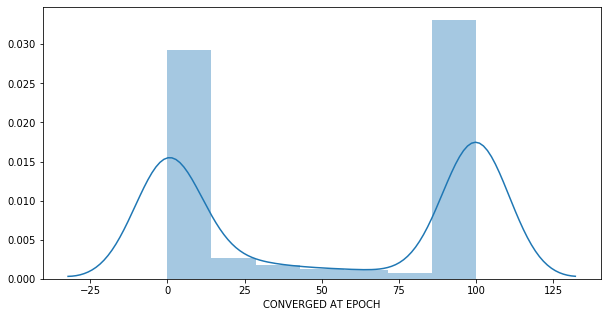

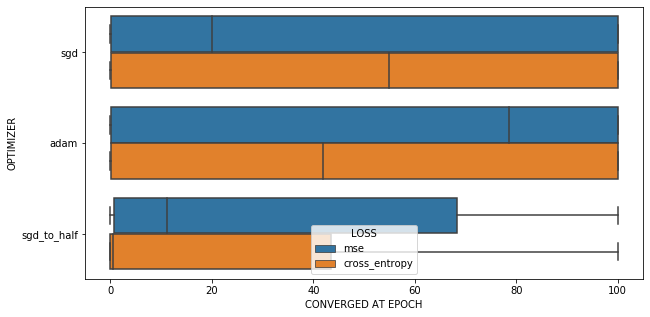

In [89]:
plt.figure(figsize=(10, 5))
sns.distplot(experiment_log.loc[experiment_log["OPTIMIZER"]=="adam", "CONVERGED AT EPOCH"])
plt.show()
plt.figure(figsize=(10, 5))
sns.boxplot(y="OPTIMIZER", x="CONVERGED AT EPOCH", hue="LOSS", data=experiment_log)
plt.show()

In [93]:
training_logs = pd.read_csv("./results/circle_mini_batch_size_lr_training_logs.csv", header=0, index_col=None, encoding="utf-8")
plot_data = training_logs.melt(id_vars=["EPOCH", "OPTIMIZER", "LOSS"], value_vars=["TRAINING F1", "VALIDATION F1"], var_name="MEASURE", value_name="F1")

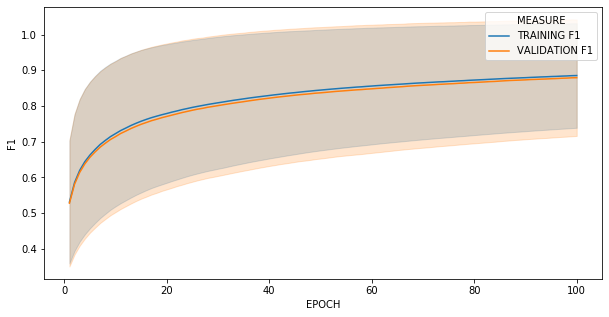

In [94]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="EPOCH", y="F1", hue="MEASURE", ci="sd", data=plot_data[plot_data["OPTIMIZER"]=="sgd"])
plt.show()

# sns.scatterplot(x="TRAINING F1", y="TEST F1",  data=experiment_log)

In [3]:
data_dir = "./data/"
reduce_data_size = True

mnist_train_set = datasets.MNIST(data_dir + 'mnist/',
                                 train=True,
                                 download=True)
mnist_test_set = datasets.MNIST(data_dir + 'mnist/',
                                train=False,
                                download=True)

mnist_train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
mnist_train_target = mnist_train_set.targets
mnist_test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
mnist_test_target = mnist_test_set.targets

fashion_mnist_train_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/',
                                                train=True,
                                                download=True)
fashion_mnist_test_set = datasets.FashionMNIST(data_dir + 'fashion_mnist/',
                                               train=False,
                                               download=True)

fashion_mnist_train_input = fashion_mnist_train_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_train_target = fashion_mnist_train_set.targets
fashion_mnist_test_input = fashion_mnist_test_set.data.view(-1, 1, 28, 28).float()
fashion_mnist_test_target = fashion_mnist_test_set.targets

In [4]:
def standardize_data(train_input, test_input):
    mean, std = train_input.mean(), train_input.std()

    return (train_input - mean) / std, (test_input - mean) / std

In [5]:
def sample_mnist_dataset(input_data, target_data, reduced_num_samples=1000):
    reduced_input_data, _, reduced_target_data, _ = train_test_split(input_data, target_data,
                                                                     train_size=reduced_num_samples,
                                                                     random_state=1,
                                                                     shuffle=True,
                                                                     stratify=target_data)
    return reduced_input_data, reduced_target_data

In [6]:
class MnistClassifier(nn.Module):
    def __init__(self, mini_batch_size=100):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.maxp1 = nn.MaxPool2d(kernel_size=2)
        if mini_batch_size > 1:
            self.bn1 = nn.BatchNorm2d(num_features=16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4)
        self.maxp2 = nn.MaxPool2d(kernel_size=2)
        if mini_batch_size > 1:
            self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        if mini_batch_size > 1:
            self.bn3 = nn.BatchNorm1d(num_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        if mini_batch_size > 1:
            self.bn4 = nn.BatchNorm1d(num_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        mini_batch_size = x.size(0)
        y = F.relu(self.maxp1(self.conv1(x)))
        if mini_batch_size > 1:
            y = self.bn1(y)
        y = F.relu(self.maxp2(self.conv2(y)))
        if mini_batch_size > 1:
            y = self.bn2(y)
        y = F.relu(self.conv3(y).view(-1, 64))
        if mini_batch_size > 1:
            y = self.bn3(y)
        y = F.relu(self.fc1(y))
        if mini_batch_size > 1:
            y = self.bn4(y)
        y = F.relu(self.fc2(y))
        return y

In [7]:
def deep_model_params_and_loss_gradients_to_flat_vector(model_params):
    return (torch.cat([param.data.view(-1).cpu() for param in model_params]), torch.cat([param.grad.view(-1).cpu() for param in model_params]))

In [8]:
class SgdToHalf(torch.optim.Optimizer):
    def __init__(self, params, lr, burn_in=10):
        self.params = params
        self.lr = lr
        self.burn_in = burn_in
        self.n = 1
        self.s = [0, ]
        self.tau = 0
        self.prev_grad = None
        defaults = {"lr": lr, "burn_in": burn_in, "n": 1, "s": [0, ], "tau": 0, "prev_grad": None}
        super(SgdToHalf, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SgdToHalf, self).__setstate__(state)
        
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        group = self.param_groups[0]
        lr = group["lr"]
        burn_in = group["burn_in"]
        n = group["n"]
        s = float(group["s"][-1])
        tau = group["tau"]
        
        params = group["params"]
        for p in params:
            if p.grad is None:
                continue
            g_p = p.grad
            p.add_(g_p, alpha=-lr)
        
        _, g = deep_model_params_and_loss_gradients_to_flat_vector(params)
        if n == 1:
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
        else:
            g_prev = group["prev_grad"]
            s += torch.dot(g.view(-1), g_prev.view(-1))
            if n > (tau + burn_in) and s < 0:
                self.tau = group["tau"] = n
                s = 0
                self.lr = group["lr"] = lr / 2
            self.s.append(s)
            group["s"].append(s)
            self.prev_grad = group["prev_grad"] = torch.clone(g).detach()
            
        self.n = group["n"] = n+1
                
        return loss

    def converged(self):
        return self.n > (self.tau + self.burn_in) and self.s[-1] < 0 and self.lr < 1e-10

In [9]:
def train_model(model, train_input, train_target,
                num_epochs=25, lr=1e-1, mini_batch_size=100,
                adam=False, sgd_new=False, criterion=nn.CrossEntropyLoss(), verbose=False):
    if adam:
        optimizer = Adam(model.parameters(), lr=lr)
    else:
        if sgd_new:
            optimizer = SgdToHalf(model.parameters(), lr=lr)
        else:
            optimizer = SGD(model.parameters(), lr=lr)
    criterion = criterion.cuda()
    num_samples = train_input.size(0)
    param_values_series=[]
    loss_gradients_series=[]
    converged_early = False
    for e in range(1, num_epochs+1):
        if converged_early:
            break
        sum_loss=0
        for b in range(0, num_samples, mini_batch_size):
            train_input_mini_batch = train_input[b:min(b+mini_batch_size, num_samples)]
            train_target_mini_batch = train_target[b:min(b+mini_batch_size, num_samples)]
            optimizer.zero_grad()
            prediction_mini_batch = model(train_input_mini_batch)
            loss = criterion(prediction_mini_batch, train_target_mini_batch)
            sum_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                param_values, loss_gradients = deep_model_params_and_loss_gradients_to_flat_vector(list(model.parameters()))
                param_values_series.append(param_values)
                loss_gradients_series.append(loss_gradients)
            optimizer.step()
            torch.cuda.empty_cache()
            if sgd_new and optimizer.converged():
                converged_early = True
                break
        if verbose:
            print("Epoch {} Loss: {}".format(e, sum_loss))
    param_values_series = torch.stack(param_values_series)
    loss_gradients_series = torch.stack(loss_gradients_series)
    if sgd_new:
        if verbose:
            print("Convergence reached at iteration:", optimizer.tau)
            print("Final learning rate value:", optimizer.lr)
        return model, param_values_series, loss_gradients_series, torch.FloatTensor(optimizer.s)
    else:
        return model, param_values_series, loss_gradients_series, None

In [10]:
def test_model(model, test_input, test_target):
    model.train(False)
    prediction = model(test_input)
    predicted_labels = torch.argmax(prediction, dim=1)
    if len(test_target.size()) > 1:
        test_target = torch.argmax(test_target, dim=1)
    accuracy = (predicted_labels == test_target).float().mean().item()
    return accuracy

In [11]:
def estimate_convergence_threshold_phlug_diagnostic(loss_gradients_series, burn_in=1):
    num_sgd_iterations_performed = len(loss_gradients_series)
    s_series = [0, ]
    convergence_threshold_set=False
    convergence_threshold = np.inf
    for n in range(1, num_sgd_iterations_performed):
        s_n = s_series[n-1] + torch.dot(loss_gradients_series[n], loss_gradients_series[n-1]).item()
        s_series.append(s_n)
        if not convergence_threshold_set and n > burn_in and s_n < 0:
            convergence_threshold = n
            convergence_threshold_set = True
    s_series = np.array(s_series)
    return convergence_threshold, s_series

In [12]:
if reduce_data_size:
    mnist_train_input, mnist_train_target = sample_mnist_dataset(mnist_train_input, mnist_train_target)
    mnist_test_input, mnist_test_target = sample_mnist_dataset(mnist_test_input, mnist_test_target)
mnist_train_input, mnist_test_input = standardize_data(mnist_train_input, mnist_test_input)
mnist_train_input = mnist_train_input.cuda()
mnist_train_target = mnist_train_target.cuda()
mnist_test_input = mnist_test_input.cuda()
mnist_test_target = mnist_test_target.cuda()

In [13]:
mini_batch_size = 100
mnist_model, mnist_param_values, mnist_training_loss_grads, mnist_s_series = train_model(MnistClassifier(mini_batch_size).cuda(),
                                                                                         mnist_train_input,
                                                                                         F.one_hot(mnist_train_target, 10).float(),
                                                                                         lr=0.7,
                                                                                         num_epochs=100,
                                                                                         mini_batch_size=mini_batch_size,
                                                                                         sgd_new=True,
                                                                                         criterion=nn.MSELoss(),
                                                                                        verbose=True)

Epoch 1 Loss: 1.1791109777987003
Epoch 2 Loss: 0.28365224972367287
Epoch 3 Loss: 0.1445870315656066
Epoch 4 Loss: 0.10794720984995365
Epoch 5 Loss: 0.09331915341317654
Epoch 6 Loss: 0.08621562318876386
Epoch 7 Loss: 0.08009042730554938
Epoch 8 Loss: 0.07469086488708854
Epoch 9 Loss: 0.06993525940924883
Epoch 10 Loss: 0.0656735710799694
Epoch 11 Loss: 0.06172029580920935
Epoch 12 Loss: 0.05833400692790747
Epoch 13 Loss: 0.055066051660105586
Epoch 14 Loss: 0.05185103719122708
Epoch 15 Loss: 0.04920290783047676
Epoch 16 Loss: 0.04770036041736603
Epoch 17 Loss: 0.046929034404456615
Epoch 18 Loss: 0.04653886565938592
Epoch 19 Loss: 0.04633594024926424
Epoch 20 Loss: 0.04623255436308682
Epoch 21 Loss: 0.046183165395632386
Epoch 22 Loss: 0.046155619667842984
Epoch 23 Loss: 0.046140247490257025
Epoch 24 Loss: 0.046131587820127606
Epoch 25 Loss: 0.046127272536978126
Epoch 26 Loss: 0.04612457752227783
Epoch 27 Loss: 0.04612312978133559
Epoch 28 Loss: 0.04612237261608243
Epoch 29 Loss: 0.04612198

In [14]:
test_model(mnist_model, mnist_test_input, mnist_test_target)

0.9220000505447388

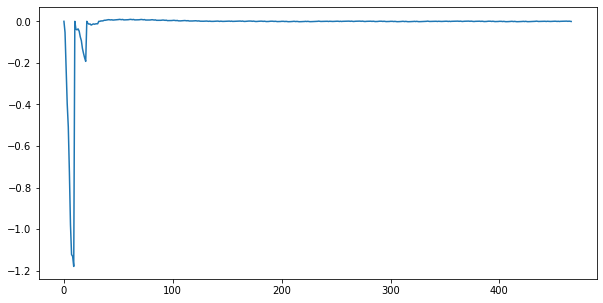

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mnist_s_series)
plt.show()

In [16]:
mnist_conv_thresh, mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(mnist_training_loss_grads,
                                                                                    burn_in=10)
mnist_conv_thresh

11

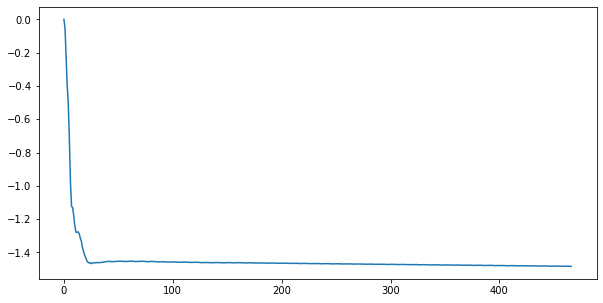

In [17]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mnist_s_series)
plt.show()

In [18]:
if reduce_data_size:
    fashion_mnist_train_input, fashion_mnist_train_target = sample_mnist_dataset(fashion_mnist_train_input,
                                                                                 fashion_mnist_train_target)
    fashion_mnist_test_input, fashion_mnist_test_target = sample_mnist_dataset(fashion_mnist_test_input,
                                                                               fashion_mnist_test_target)
fashion_mnist_train_input, fashion_mnist_test_input = standardize_data(fashion_mnist_train_input,
                                                                       fashion_mnist_test_input)
fashion_mnist_train_input = fashion_mnist_train_input.cuda()
fashion_mnist_train_target = fashion_mnist_train_target.cuda()
fashion_mnist_test_input = fashion_mnist_test_input.cuda()
fashion_mnist_test_target = fashion_mnist_test_target.cuda()

In [19]:
fashion_mnist_model, fashion_mnist_param_values, fashion_mnist_training_loss_grads, fashion_mnist_s_series = train_model(MnistClassifier(mini_batch_size).cuda(),
                                                                                             fashion_mnist_train_input,
                                                                                             fashion_mnist_train_target,
                                                                                             lr=0.05,
                                                                                             num_epochs=100,
                                                                                             mini_batch_size=mini_batch_size,
                                                                                             sgd_new=True, verbose=True)

Epoch 1 Loss: 13.211354374885559
Epoch 2 Loss: 6.4151251912117
Epoch 3 Loss: 4.65219709277153
Epoch 4 Loss: 3.489443004131317
Epoch 5 Loss: 2.7199286967515945
Epoch 6 Loss: 1.9340814054012299
Epoch 7 Loss: 1.5432416200637817
Epoch 8 Loss: 1.2332655563950539
Epoch 9 Loss: 0.9953883290290833
Epoch 10 Loss: 0.8141633868217468
Epoch 11 Loss: 0.6748586148023605
Epoch 12 Loss: 0.5690636299550533
Epoch 13 Loss: 0.4892520010471344
Epoch 14 Loss: 0.42744434624910355
Epoch 15 Loss: 0.3779377844184637
Epoch 16 Loss: 0.3394611570984125
Epoch 17 Loss: 0.3076034691184759
Epoch 18 Loss: 0.2816105652600527
Epoch 19 Loss: 0.2586976960301399
Epoch 20 Loss: 0.23997803777456284
Epoch 21 Loss: 0.22377495747059584
Epoch 22 Loss: 0.20905764121562243
Epoch 23 Loss: 0.19659019634127617
Epoch 24 Loss: 0.185500911436975
Epoch 25 Loss: 0.17562928516417742
Epoch 26 Loss: 0.1667641680687666
Epoch 27 Loss: 0.15885075833648443
Epoch 28 Loss: 0.15157821215689182
Epoch 29 Loss: 0.1450312277302146
Epoch 30 Loss: 0.13896

In [20]:
test_model(fashion_mnist_model, fashion_mnist_test_input, fashion_mnist_test_target)

0.7950000166893005

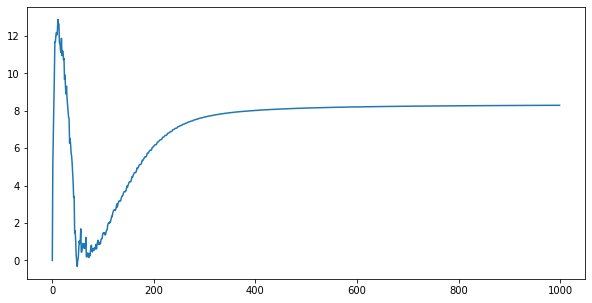

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fashion_mnist_s_series)
plt.show()

In [22]:
fashion_mnist_conv_thresh, fashion_mnist_s_series = estimate_convergence_threshold_phlug_diagnostic(fashion_mnist_training_loss_grads,
                                                                                                    burn_in=10)
fashion_mnist_conv_thresh

48

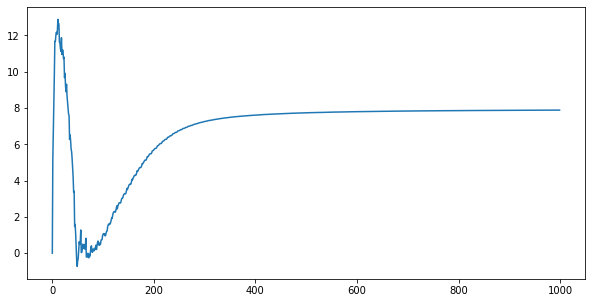

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fashion_mnist_s_series)
plt.show()

In [24]:
def generate_simple_linear_classification_dataset(num_samples=1000, num_features=2, onehot_targets=False):
    circle_radius = np.sqrt(2 / np.pi)
    input_data = torch.empty(num_samples * 2, num_features).uniform_(-1, 1)
    target_data = (input_data.pow(2).sum(dim=1) < circle_radius**2).long()
    if onehot_targets:
        target_data = F.one_hot(target_data, num_classes=2).float()
    return input_data[:num_samples], target_data[:num_samples], input_data[num_samples:], target_data[num_samples:]

In [25]:
linear_train_input, linear_train_target, linear_test_input, linear_test_target = generate_simple_linear_classification_dataset(onehot_targets=True)
linear_train_input, linear_test_input = standardize_data(linear_train_input, linear_test_input)
linear_train_input = linear_train_input.cuda()
linear_train_target = linear_train_target.cuda()
linear_test_input = linear_test_input.cuda()
linear_test_target = linear_test_target.cuda()

In [26]:
linear_model, linear_param_values, linear_training_loss_grads, linear_s_series = train_model(nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 2), nn.Sigmoid()).cuda(),
                                                                        linear_train_input,
                                                                        linear_train_target,
                                                                        sgd_new=True,
                                                                        num_epochs=250,
                                                                        lr=2.5, mini_batch_size=100,
                                                                        criterion=nn.MSELoss(), verbose=True)

Epoch 1 Loss: 2.3281644880771637
Epoch 2 Loss: 1.955846831202507
Epoch 3 Loss: 1.7645504623651505
Epoch 4 Loss: 1.662224143743515
Epoch 5 Loss: 1.5707115232944489
Epoch 6 Loss: 1.4850385934114456
Epoch 7 Loss: 1.405565544962883
Epoch 8 Loss: 1.3379103764891624
Epoch 9 Loss: 1.3006867617368698
Epoch 10 Loss: 1.2723272740840912
Epoch 11 Loss: 1.257992871105671
Epoch 12 Loss: 1.250327929854393
Epoch 13 Loss: 1.2461105659604073
Epoch 14 Loss: 1.2426388040184975
Epoch 15 Loss: 1.2407561615109444
Epoch 16 Loss: 1.2397125735878944
Epoch 17 Loss: 1.2388507425785065
Epoch 18 Loss: 1.2383819818496704
Epoch 19 Loss: 1.238121747970581
Epoch 20 Loss: 1.237906739115715
Epoch 21 Loss: 1.237789809703827
Epoch 22 Loss: 1.23772481828928
Epoch 23 Loss: 1.237671136856079
Epoch 24 Loss: 1.2376419082283974
Epoch 25 Loss: 1.2376256361603737
Epoch 26 Loss: 1.2376122549176216
Epoch 27 Loss: 1.2376048490405083
Epoch 28 Loss: 1.237600825726986
Epoch 29 Loss: 1.2375974133610725
Epoch 30 Loss: 1.2375956028699875
E

In [27]:
test_model(linear_model, linear_test_input, linear_test_target)

0.9260000586509705

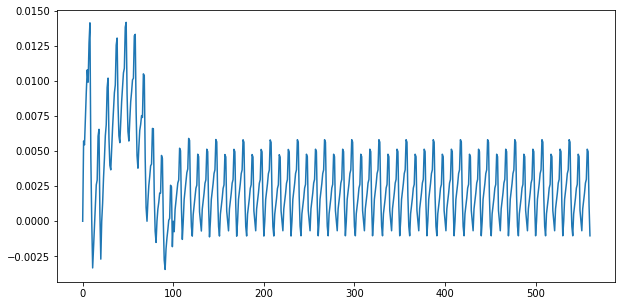

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=linear_s_series)
plt.show()

In [29]:
linear_conv_thresh, linear_s_series = estimate_convergence_threshold_phlug_diagnostic(linear_training_loss_grads,
                                                                                      burn_in=10)
linear_conv_thresh

11

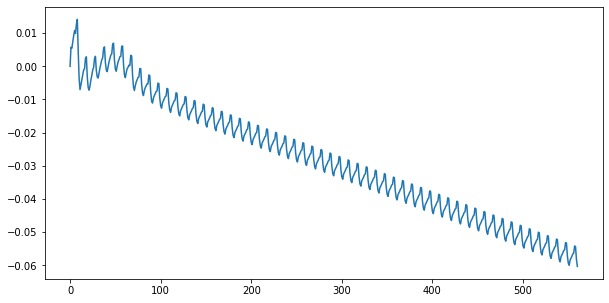

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=linear_s_series)
plt.show()

In [31]:
from sklearn.decomposition import PCA


def pca_compress_dataset(dataset, num_components=2):
    """
    Helper function to use Principal Component Analysis to reduce the dimensionality of a dataset

    :param dataset: feature data, pandas.DataFrame object
    :param num_components: number of principal components to preserve, positive int, optional, default value is 2

    :returns: PCA-projected dataset, PCA projection matrix
    """

    pca = PCA(num_components, random_state=seed)
    pca.fit(dataset)
    pca_projection = pca.components_
    compressed_dataset = pca.transform(dataset)
    return compressed_dataset, pca_projection

In [32]:
linear_param_values_compressed, _ = pca_compress_dataset(linear_param_values)
criterion=nn.MSELoss()
x, y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        x_val, y_val = x[i, j], y[i, j]
        with torch.no_grad():
            first_params = list(linear_model.parameters())[0]
            first_params[0, 0] = x_val
            first_params[0, 1] = y_val
            z[i, j] = criterion(linear_model(linear_test_input), linear_test_target).item()

In [39]:
simulations_s_series=[]
for i in range(100):
    print(i)
    linear_model = nn.Sequential(nn.Linear(2, 64), nn.ReLU(), nn.Linear(64, 2), nn.Sigmoid())
    linear_model, linear_param_values, linear_training_loss_grads, linear_s_series = train_model(linear_model.cuda(),
                                                                        linear_train_input,
                                                                        linear_train_target,
                                                                        sgd_new=True,
                                                                        num_epochs=100,
                                                                        lr=1, mini_batch_size=100,
                                                                        criterion=nn.MSELoss())
    # _, linear_s_series = estimate_convergence_threshold_phlug_diagnostic(linear_training_loss_grads, burn_in=10)
    simulations_s_series.append((linear_param_values, linear_s_series))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [40]:
param_data = np.vstack([simulations_s_series[i][0] for i in range(100)])
s_data = np.concatenate([simulations_s_series[i][1] for i in range(100)])
data = np.hstack((param_data[:, :2], (s_data < 0).reshape(-1, 1)))
data = pd.DataFrame(data, columns=["param0","param1","converged"])
conv_rect_x1, conv_rect_y1 = data.groupby("converged").quantile(0.025).loc[1, :]
conv_rect_x2, conv_rect_y2 = data.groupby("converged").quantile(0.975).loc[1, :]
conv_ell_x, conv_ell_y = data.groupby("converged").mean().loc[1, :]
conv_ell_d1 = conv_rect_x2 - conv_rect_x1
conv_ell_d2 = conv_rect_y2 - conv_rect_y1
conv_rect_x1, conv_rect_y1, conv_rect_x2, conv_rect_y2

(-0.7744265079498291,
 -0.784119987487793,
 0.8749446392059326,
 0.8734336256980896)

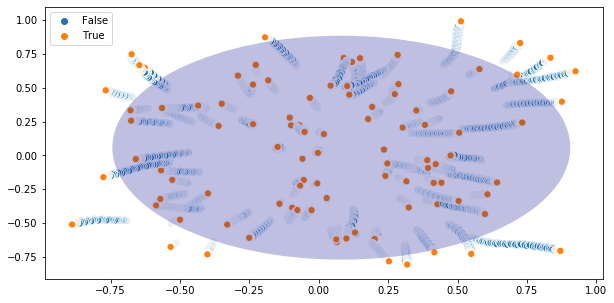

In [41]:
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(10, 5))
# sns.lineplot(x=param_data[:, 0], y=param_data[:, 1], sort=False)
conv_ell = Ellipse(xy=(conv_ell_x, conv_ell_y),
              width=conv_ell_d1,
              height=conv_ell_d2, fill=True, facecolor="darkblue", alpha=0.25)
sns.scatterplot(x=param_data[:, 0], y=param_data[:, 1], hue=(s_data < 0), s=50).add_patch(conv_ell)
#plt.contourf(x, y, z, 100, cmap="hot")
#plt.colorbar()
plt.show()

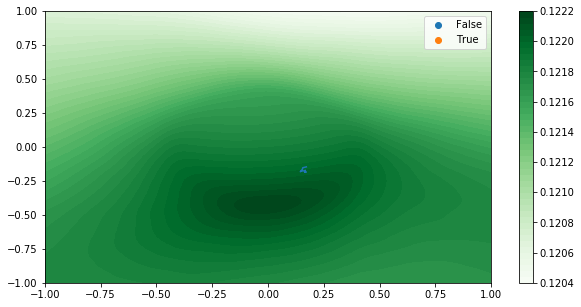

In [43]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=mnist_param_values[:, 0], y=mnist_param_values[:, 1], sort=False)
sns.scatterplot(x=mnist_param_values[:, 0], y=mnist_param_values[:, 1], hue=(mnist_s_series < 0), s=50)
plt.contourf(x, y, z, 50, cmap="Greens")
plt.colorbar()
plt.show()